In [2]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim, string
from nltk.corpus import stopwords
from collections import Counter
from gensim.summarization import summarize
from gensim.summarization import keywords

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from tqdm import tqdm

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

%matplotlib inline

In [27]:
# A custom function to clean the text before sending it into the vectorizer
def cleanText(text):
    
    # replace ;
    text = text.replace(" ; ", "\n")
    
    table = str.maketrans('', '', string.punctuation)
    # get rid of punctuation
    text = text.translate(table)
    
    # get rid of newlines
    text = text.strip().replace("\n", ". ").replace("\r", ".")
    
    # replace twitter @mentions
    mentionFinder = re.compile(r"@[a-z0-9_]{1,15}", re.IGNORECASE)
    text = mentionFinder.sub("@MENTION", text)
    
    # replace HTML symbols
    text = text.replace("&amp;", "and").replace("&gt;", ">").replace("&lt;", "<")
    
    # lowercase
    text = text.lower()

    return text

def calc_score(ref, comp, debug=False):
    '''gives the number of items in ref that is also found in comp'''
    ## check if it is a list of strings
    if not isinstance(ref, list):
        ref = str(ref).split()
    if not isinstance(comp, list):
        comp = str(comp).split()
        
    s_ref = set(ref)
    s_comp = set(comp)
    s_inter = s_comp.intersection(s_ref)
    if debug:
        print(s_ref, len(s_ref))
        print(s_comp)
        print(s_inter, len(s_inter))
    return len(s_inter)/len(s_ref)

In [28]:
# A custom stoplist
STOPLIST = set(stopwords.words('english') + ["n't", "'s", "'m", "ca"] + list(ENGLISH_STOP_WORDS))
# List of symbols we don't care about
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-----", "---", "...", "“", "”", "'ve", "\n", "", " ", "\n\n", "npr"]

def lemming(data, keeptype=["NOUN", "PROPN", "NUM", "ADJ", "ADV"], doalpha=True, dostop=True):
    tokens = []
    for tok in data:
        
        # stoplist the tokens
        if dostop:
            if tok.text not in STOPLIST:
                pass
            else:
                continue
            ##check if the token is stopword
            if not tok.is_stop:
                pass
            else:
                continue
        else:
            pass
        
        # stoplist symbols
        if tok.text not in SYMBOLS:
            pass
        else: 
            continue
        
        ##check if the token is alpha
        if doalpha:
            if tok.is_alpha:
                pass
            else:
                continue
        else:
            pass
        
        ##check if the token is noun
        if len(keeptype) > 1:
            if tok.pos_ in keeptype:
                pass
            else:
                continue
        else:
            pass
    
        # lemmatize
        if tok.lemma_ != "-PRON-" :
            tokens.append(tok.lemma_.lower().strip())
        else:
            tokens.append(tok.lower_)
    
    # remove large strings of whitespace
    return tokens

In [29]:
# Initialize spacy 'en' model
nlp = spacy.load('en')

# Initialize vectorizer
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=1,                        # minimum reqd occurences of a word 
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

In [44]:
all_token = []
all_token_alltype = []
all_sumtoken = []
all_gensim = []
N = 419 ##304 NPR, 96 conv, 419 story
path = 'Data/NPR_story/'
for i in tqdm(range(N)):
    test_text = []
    test_sumtext   = []
    with open(path + str(i) + '_trans.txt', 'r') as myfile:
        test_text.append(cleanText(myfile.read()))
    with open(path + str(i) + '.txt', 'r') as myfile:
        test_sumtext.append(cleanText(myfile.read()))
    #print(test_text[-1])
    
    ## try gensim
    sum_gensim = summarize("".join(test_text), ratio=0.1, split=True)
    ## calculate the maximum score
    nlp_test_text = nlp("".join(test_text))
    all_token.append(lemming(nlp_test_text))
    all_token_alltype.append(lemming(nlp_test_text, doalpha=False, dostop=True, keeptype=[]))
    all_sumtoken.append(lemming(nlp("".join(test_sumtext)), doalpha=False, dostop=True, keeptype=[]))
    all_gensim.append(lemming(nlp("".join(sum_gensim)), doalpha=False, dostop=True, keeptype=[]))

100%|██████████| 419/419 [00:52<00:00,  8.03it/s]


In [49]:
base_rate = []
my_rate  = []
gensim_rate = []
for i in tqdm(range(N)):
#for i in tqdm(range(1)):
    ## calculate the maximum score
    test_token = all_token[i]
    test_token_alltype = all_token_alltype[i]
    test_sumtoken = all_sumtoken[i]
    test_gensim_token = all_gensim[i]
    
    best_score = calc_score(ref=test_sumtoken, comp=test_token_alltype, debug=False)
    #print("best score", best_score)

    length = len(test_sumtoken)
    common_words_alltype = [w[0] for w in Counter(test_token_alltype).most_common(length)]
    #print(" ".join(common_words_alltype))
    base_score =  calc_score(ref=test_sumtoken, comp=common_words_alltype, debug=False)
    #print("baseline score", base_score)

#     # Predict the topic
#     topic = predict_topic(text = [" ".join(test_token)], nwords=length)
#     #print(" ".join(topic))

    topic = [w[0] for w in Counter(test_token).most_common(length)]
    my_score = calc_score(ref=test_sumtoken, comp=topic, debug=False)
    #print("my score", my_score)
    #print(" ".join(test_sumtoken))
    
    #test_gensim_token = keywords(" ".join(test_token_alltype), words=length)
    #print(test_gensim_token)
    gensim_score = calc_score(ref=test_sumtoken, comp=test_gensim_token, debug=False)
    
    base_rate.append(base_score/best_score)
    my_rate.append(my_score/best_score)
    gensim_rate.append(gensim_score/best_score)
    
#     if base_score/best_score > 0.9:
#         print(" ".join(common_words_alltype))
#         print(" ".join(topic))
#         print(" ".join(test_sumtoken))
#         calc_score(ref=test_sumtoken, comp=common_words_alltype, debug=True)
#         print(base_score, best_score, my_score)


100%|██████████| 419/419 [00:00<00:00, 6277.26it/s]

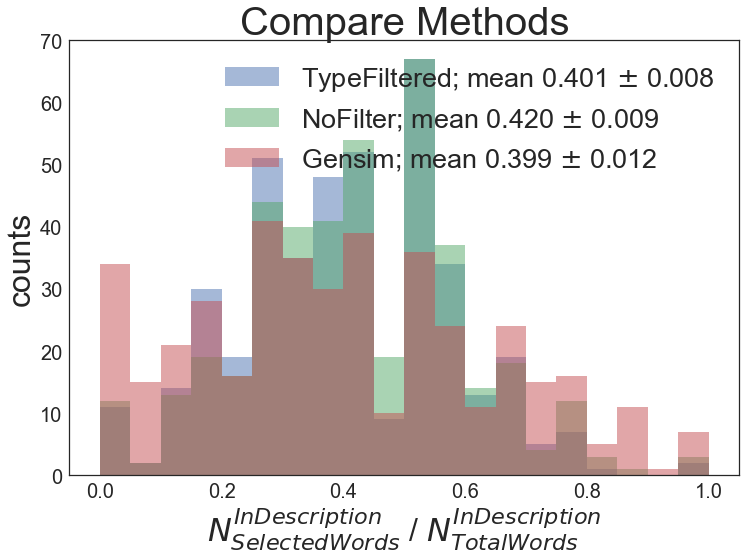

In [50]:
plt.clf()
plt.figure(figsize=(12, 8))
mybins=np.arange(0, 1.05, 0.05)
plt.hist(my_rate, alpha=0.5, bins=mybins, label="TypeFiltered; mean %.3f %s %.3f" % (np.mean(np.array(my_rate)), r'$\pm$', np.std(np.array(my_rate))/np.sqrt(N)))
plt.hist(base_rate, alpha=0.5, bins=mybins, label="NoFilter; mean %.3f %s %.3f " % (np.mean(np.array(base_rate)), r'$\pm$', np.std(np.array(base_rate)/np.sqrt(N))))
plt.hist(gensim_rate, alpha=0.5, bins=mybins, label="Gensim; mean %.3f %s %.3f " % (np.mean(np.array(gensim_rate)), r'$\pm$', np.std(np.array(gensim_rate)/np.sqrt(N))))
plt.ylim(0, 70)
plt.xlabel(r"$N_{SelectedWords}^{InDescription}$ / $N_{TotalWords}^{InDescription}$", fontsize=32)
plt.ylabel("counts", fontsize=32)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("Compare Methods", fontsize=40)
plt.legend(fontsize=27)
plt.savefig("Plot/" + path.split("/")[1] + "_compare.pdf")
plt.show()

In [51]:
print(" ".join(common_words_alltype))
print(" ".join(topic))

time know hand right school want not ride good record story carol anderson come go like child smart trouble
time hand right school not ride good story carol anderson child smart trouble principal office elementary home conversation historical


In [53]:
print(" ".join(test_sumtoken))
print(" ".join(test_gensim_token))

berryl anderson class clown troublemaker grow mom teach not smart good person respectful people judge dekalb county gaap 20100917
come collect ah yes go principal office times.on ride home short ride elementary school right corner.at time want there.and time like fifth grade not want think


In [43]:
print(" ".join(test_text))
summarize("".join(test_text), ratio=0.1, split=True)

in the time now for historical in the project that record stories from around the country. today we hear from carol anderson and her mother virginia. they came destroy going inland had to talk about what barrel was like as a child. turns out she was the family troublemaker. i was always. pretty smart academically but my mouth would give me a lot of trouble. and found myself in the principals office all are as you know. because youd have to come to collect me and to take me ah yes i went to the principals office so many times. the u you made up for the elephant children. katia you always the leader. when they get in trouble i knew to call you first if i knew the works of your haiti and i remember when one day. an elementary school is quite his clients. essentially bringing my a game dawn a little bit of standup comedy. and follow the classroom and miss clayton just had this look bob. frustration on her face. she had her hands on her hips. and she wanted me to sit down. she asked me poli

['because youd have to come to collect me and to take me ah yes i went to the principals office so many times.',
 'on that ride home when there was a short ride from elementary school which is right around the corner.',
 'at times what i wanted you there.',
 'and at times like in fifth grade one i didnt want you think.']

In [17]:
print("".join(test_sumtext))

berryl anderson was a class clown and troublemaker when she was growing up but her mom taught her that it wasnt enough to be smart she also had to be a good person and be respectful of other people now shes a judge in dekalb county gaap 20100917


## Merge all txt files into one

In [47]:
test_text = []
test_sumtext   = []
for i in tqdm(range(N)):
    with open(path + str(i) + '_trans.txt', 'r') as myfile:
        test_text.append(cleanText(myfile.read()))
    with open(path + str(i) + '.txt', 'r') as myfile:
        cleaned_sum = cleanText(myfile.read())
        ## pop the last date out
        test_sumtext.append(" ".join(cleaned_sum.split(" ")[:-1]))

100%|██████████| 419/419 [00:00<00:00, 1080.64it/s]


In [48]:
out_text = open('all_trans.txt', 'w')
for item in test_text:
    out_text.write("%s\n" % item)
out_text.close()

out_sumtext = open('all_sum.txt', 'w')
for item in test_sumtext:
    out_sumtext.write("%s\n" % item)
out_sumtext.close()

## Gensim fasttext

In [2]:
from gensim.models import FastText
sentences_1 = [["cat", "say", "meow"], ["dog", "say", "woof"]]
sentences_2 = [["dude", "say", "wazzup!"]]

model = FastText(min_count=1)
model.build_vocab(sentences_1)
model.train(sentences_1, total_examples=model.corpus_count, epochs=model.iter)
model.build_vocab(sentences_2, update=True)
model.train(sentences_2, total_examples=model.corpus_count, epochs=model.iter)

/Users/renormalization/anaconda/lib/python3.6/site-packages/gensim/models/fasttext.py:273: DeprecationWarning: Call to deprecated `bucket` (Attribute will be removed in 4.0.0, use trainables.bucket instead).
  self.wv.bucket = self.bucket
/Users/renormalization/anaconda/lib/python3.6/site-packages/gensim/models/fasttext.py:396: DeprecationWarning: Call to deprecated `layer1_size` (Attribute will be removed in 4.0.0, use self.trainables.layer1_size instead).
  l1_size = self.layer1_size * np.dtype(np.float32).itemsize
/Users/renormalization/anaconda/lib/python3.6/site-packages/gensim/models/fasttext.py:400: DeprecationWarning: Call to deprecated `bucket` (Attribute will be removed in 4.0.0, use trainables.bucket instead).
  num_buckets = self.bucket
/Users/renormalization/anaconda/lib/python3.6/site-packages/gensim/models/fasttext.py:409: DeprecationWarning: Call to deprecated `min_n` (Attribute will be removed in 4.0.0, use wv.min_n instead).
  ngrams = _compute_ngrams(word, self.min_n

/Users/renormalization/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  import sys
/Users/renormalization/anaconda/lib/python3.6/site-packages/gensim/models/fasttext.py:396: DeprecationWarning: Call to deprecated `layer1_size` (Attribute will be removed in 4.0.0, use self.trainables.layer1_size instead).
  l1_size = self.layer1_size * np.dtype(np.float32).itemsize
/Users/renormalization/anaconda/lib/python3.6/site-packages/gensim/models/fasttext.py:400: DeprecationWarning: Call to deprecated `bucket` (Attribute will be removed in 4.0.0, use trainables.bucket instead).
  num_buckets = self.bucket
/Users/renormalization/anaconda/lib/python3.6/site-packages/gensim/models/fasttext.py:409: DeprecationWarning: Call to deprecated `min_n` (Attribute will be removed in 4.0.0, use wv.min_n instead).
  ngrams = _compute_ngrams(word, self.min_n, self.max_n)
/Users/renormaliza

In [3]:
say_vector = model['say']

/Users/renormalization/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [4]:
say_vector

array([ -2.48374348e-03,   1.28183200e-03,   2.78071064e-04,
         1.17748801e-03,  -2.84763589e-03,   9.77993477e-04,
         7.77854701e-04,   3.20158107e-03,  -3.23760835e-03,
         7.47663376e-04,  -2.53082108e-04,  -1.91538595e-03,
         4.54709720e-04,  -5.62755333e-04,  -3.87221808e-03,
         1.28175726e-03,  -1.76023715e-03,   7.72499421e-04,
         1.95931108e-03,  -2.86182249e-03,  -4.55376838e-04,
         3.05658067e-03,   2.28731777e-03,   8.24262388e-05,
        -1.02034304e-03,   3.90086439e-03,  -2.50886264e-03,
        -1.91701506e-03,  -2.79970840e-03,  -6.84790313e-04,
        -3.51232733e-03,   7.81246563e-05,  -1.41762511e-03,
         3.18209408e-03,   1.07611215e-03,  -3.61893000e-03,
         1.30862638e-03,   1.16036169e-03,  -3.37773818e-03,
         4.24797880e-03,  -1.71071826e-03,   6.81362930e-04,
        -2.27297656e-03,   2.86741694e-03,  -1.21385325e-04,
         5.62858162e-03,   2.79778475e-03,   1.07019977e-03,
        -1.81176583e-03,

In [60]:
audio_length= "%.1g sec" % 3.111
audio_length

'3 sec'